# Project - HopperBulletEnv with Soft Actor Critic (SAC)

In [1]:
import gym
import pybullet_envs
import pybullet_envs.bullet as bul
import numpy as np
import torch
from sac_agent import soft_actor_critic_agent
from replay_memory import ReplayMemory

seed=0  
env = gym.make('HopperBulletEnv-v0')

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import os
os.environ['PYTHONHASHSEED']=str(seed)

np.random.seed(seed)
env.seed(seed)
max_steps = env._max_episode_steps
print('max_steps: ', max_steps)

batch_size=256

LEARNING_RATE=0.0003 
eval=True  ## 
start_steps=10000 ## Steps sampling random actions
replay_size=1000000 ## size of replay buffer
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# alpha=0.2  # relative importance of the entropy
# gamma=0.99  # discount factor 
# tau=0.005  # target smoothing coefficient(τ)

agent = soft_actor_critic_agent(env.observation_space.shape[0], env.action_space, \
        device=device, hidden_size=256, seed=seed, \
        lr=LEARNING_RATE, gamma=0.99, tau=0.005, alpha=0.2)

memory = ReplayMemory(seed, replay_size)

print('device: ', device)
print('state dim: ', env.observation_space.shape[0])
print('action dim: ', env.action_space)
print('leraning rate: ', LEARNING_RATE)\

threshold = env.spec.reward_threshold

print('threshold: ', threshold)

current_dir=D:\Users\user\Anaconda2_02Aug2019\envs\ml2\lib\site-packages\pybullet_envs\bullet
max_steps:  1000
device:  cuda:0
state dim:  15
action dim:  Box(3,)
leraning rate:  0.0003
threshold:  2500.0


In [2]:
def save(agent, directory, filename, episode, reward):
    torch.save(agent.policy.state_dict(), '%s/%s_actor_%s_%s.pth' % (directory, filename, episode, reward))
    torch.save(agent.critic.state_dict(), '%s/%s_critic_%s_%s.pth' % (directory, filename, episode, reward))

In [3]:
import time
from  collections  import deque

def sac_train(max_steps):

    total_numsteps = 0
    updates = 0
    num_episodes = 20000
    updates=0

    time_start = time.time()
    scores_deque = deque(maxlen=100)
    scores_array = []
    avg_scores_array = [] 
    
    for i_episode in range(num_episodes): 
        episode_reward = 0
        episode_steps = 0
        done = False
        state = env.reset()

        for step in range(max_steps):    
            if start_steps > total_numsteps:
                action = env.action_space.sample()  # Sample random action
            else:
                action = agent.select_action(state)  # Sample action from policy

            if len(memory) > batch_size:
                
                # Update parameters of all the networks
                agent.update_parameters(memory, batch_size, updates)

                updates += 1

            next_state, reward, done, _ = env.step(action) # Step
            episode_steps += 1
            total_numsteps += 1
            episode_reward += reward

            mask = 1 if episode_steps == env._max_episode_steps else float(not done)

            memory.push(state, action, reward, next_state, mask) # Append transition to memory

            state = next_state
            
            if done:
                break

        scores_deque.append(episode_reward)
        scores_array.append(episode_reward)        
        avg_score = np.mean(scores_deque)
        avg_scores_array.append(avg_score)
        max_score = np.max(scores_deque)
        
        if i_episode % 100 == 0 and i_episode > 0:
            reward_round = round(episode_reward, 2)
            save(agent, 'dir_hopper_sac_0.0003', 'weights', str(i_episode), str(reward_round))

        s =  (int)(time.time() - time_start)
            
        print("Ep.: {}, Total Steps: {}, Ep.Steps: {}, Score: {:.3f}, Avg.Score: {:.3f}, Max.Score: {:.3f}, Time: {:02}:{:02}:{:02}".\
            format(i_episode, total_numsteps, episode_steps, episode_reward, avg_score, max_score, \
                  s//3600, s%3600//60, s%60))

                    
        if (avg_score > threshold):
            print('Solved environment with Avg Score:  ', avg_score)
            break;
            
    return scores_array, avg_scores_array 

scores, avg_scores = sac_train(max_steps=max_steps)

Ep.: 0, Total Steps: 6, Ep.Steps: 6, Score: 20.509, Avg.Score: 20.509, Max.Score: 20.509, Time: 00:00:00
Ep.: 1, Total Steps: 19, Ep.Steps: 13, Score: 18.089, Avg.Score: 19.299, Max.Score: 20.509, Time: 00:00:00
Ep.: 2, Total Steps: 30, Ep.Steps: 11, Score: 16.680, Avg.Score: 18.426, Max.Score: 20.509, Time: 00:00:00
Ep.: 3, Total Steps: 41, Ep.Steps: 11, Score: 18.781, Avg.Score: 18.514, Max.Score: 20.509, Time: 00:00:00
Ep.: 4, Total Steps: 46, Ep.Steps: 5, Score: 17.558, Avg.Score: 18.323, Max.Score: 20.509, Time: 00:00:00
Ep.: 5, Total Steps: 55, Ep.Steps: 9, Score: 19.240, Avg.Score: 18.476, Max.Score: 20.509, Time: 00:00:00
Ep.: 6, Total Steps: 71, Ep.Steps: 16, Score: 17.935, Avg.Score: 18.399, Max.Score: 20.509, Time: 00:00:00
Ep.: 7, Total Steps: 79, Ep.Steps: 8, Score: 19.077, Avg.Score: 18.484, Max.Score: 20.509, Time: 00:00:00
Ep.: 8, Total Steps: 90, Ep.Steps: 11, Score: 23.179, Avg.Score: 19.005, Max.Score: 23.179, Time: 00:00:00
Ep.: 9, Total Steps: 108, Ep.Steps: 18, Sc

Ep.: 75, Total Steps: 883, Ep.Steps: 17, Score: 23.465, Avg.Score: 19.242, Max.Score: 24.662, Time: 00:00:30
Ep.: 76, Total Steps: 898, Ep.Steps: 15, Score: 15.428, Avg.Score: 19.192, Max.Score: 24.662, Time: 00:00:31
Ep.: 77, Total Steps: 909, Ep.Steps: 11, Score: 21.126, Avg.Score: 19.217, Max.Score: 24.662, Time: 00:00:31
Ep.: 78, Total Steps: 922, Ep.Steps: 13, Score: 18.278, Avg.Score: 19.205, Max.Score: 24.662, Time: 00:00:32
Ep.: 79, Total Steps: 930, Ep.Steps: 8, Score: 17.463, Avg.Score: 19.183, Max.Score: 24.662, Time: 00:00:33
Ep.: 80, Total Steps: 948, Ep.Steps: 18, Score: 25.441, Avg.Score: 19.260, Max.Score: 25.441, Time: 00:00:33
Ep.: 81, Total Steps: 959, Ep.Steps: 11, Score: 19.970, Avg.Score: 19.269, Max.Score: 25.441, Time: 00:00:34
Ep.: 82, Total Steps: 977, Ep.Steps: 18, Score: 22.768, Avg.Score: 19.311, Max.Score: 25.441, Time: 00:00:35
Ep.: 83, Total Steps: 993, Ep.Steps: 16, Score: 23.960, Avg.Score: 19.367, Max.Score: 25.441, Time: 00:00:36
Ep.: 84, Total Steps

Ep.: 149, Total Steps: 1794, Ep.Steps: 12, Score: 19.087, Avg.Score: 19.854, Max.Score: 25.441, Time: 00:01:14
Ep.: 150, Total Steps: 1805, Ep.Steps: 11, Score: 20.942, Avg.Score: 19.868, Max.Score: 25.441, Time: 00:01:14
Ep.: 151, Total Steps: 1814, Ep.Steps: 9, Score: 18.080, Avg.Score: 19.861, Max.Score: 25.441, Time: 00:01:15
Ep.: 152, Total Steps: 1833, Ep.Steps: 19, Score: 19.480, Avg.Score: 19.871, Max.Score: 25.441, Time: 00:01:16
Ep.: 153, Total Steps: 1839, Ep.Steps: 6, Score: 16.330, Avg.Score: 19.850, Max.Score: 25.441, Time: 00:01:16
Ep.: 154, Total Steps: 1848, Ep.Steps: 9, Score: 19.344, Avg.Score: 19.850, Max.Score: 25.441, Time: 00:01:17
Ep.: 155, Total Steps: 1856, Ep.Steps: 8, Score: 21.380, Avg.Score: 19.848, Max.Score: 25.441, Time: 00:01:17
Ep.: 156, Total Steps: 1875, Ep.Steps: 19, Score: 15.920, Avg.Score: 19.796, Max.Score: 25.441, Time: 00:01:18
Ep.: 157, Total Steps: 1886, Ep.Steps: 11, Score: 21.126, Avg.Score: 19.842, Max.Score: 25.441, Time: 00:01:18
Ep.: 

Ep.: 223, Total Steps: 2695, Ep.Steps: 12, Score: 21.773, Avg.Score: 20.355, Max.Score: 30.045, Time: 00:01:57
Ep.: 224, Total Steps: 2703, Ep.Steps: 8, Score: 20.798, Avg.Score: 20.387, Max.Score: 30.045, Time: 00:01:58
Ep.: 225, Total Steps: 2721, Ep.Steps: 18, Score: 21.249, Avg.Score: 20.406, Max.Score: 30.045, Time: 00:01:59
Ep.: 226, Total Steps: 2729, Ep.Steps: 8, Score: 17.376, Avg.Score: 20.351, Max.Score: 30.045, Time: 00:01:59
Ep.: 227, Total Steps: 2745, Ep.Steps: 16, Score: 20.969, Avg.Score: 20.346, Max.Score: 30.045, Time: 00:02:00
Ep.: 228, Total Steps: 2759, Ep.Steps: 14, Score: 20.341, Avg.Score: 20.376, Max.Score: 30.045, Time: 00:02:00
Ep.: 229, Total Steps: 2771, Ep.Steps: 12, Score: 19.753, Avg.Score: 20.332, Max.Score: 30.045, Time: 00:02:01
Ep.: 230, Total Steps: 2780, Ep.Steps: 9, Score: 22.367, Avg.Score: 20.347, Max.Score: 30.045, Time: 00:02:01
Ep.: 231, Total Steps: 2790, Ep.Steps: 10, Score: 17.791, Avg.Score: 20.310, Max.Score: 30.045, Time: 00:02:02
Ep.:

Ep.: 297, Total Steps: 3584, Ep.Steps: 8, Score: 15.379, Avg.Score: 20.436, Max.Score: 32.804, Time: 00:02:40
Ep.: 298, Total Steps: 3590, Ep.Steps: 6, Score: 16.069, Avg.Score: 20.297, Max.Score: 32.804, Time: 00:02:40
Ep.: 299, Total Steps: 3599, Ep.Steps: 9, Score: 17.115, Avg.Score: 20.281, Max.Score: 32.804, Time: 00:02:41
Ep.: 300, Total Steps: 3605, Ep.Steps: 6, Score: 16.969, Avg.Score: 20.216, Max.Score: 32.804, Time: 00:02:41
Ep.: 301, Total Steps: 3618, Ep.Steps: 13, Score: 16.431, Avg.Score: 20.178, Max.Score: 32.804, Time: 00:02:42
Ep.: 302, Total Steps: 3623, Ep.Steps: 5, Score: 15.993, Avg.Score: 20.150, Max.Score: 32.804, Time: 00:02:42
Ep.: 303, Total Steps: 3636, Ep.Steps: 13, Score: 18.323, Avg.Score: 20.155, Max.Score: 32.804, Time: 00:02:42
Ep.: 304, Total Steps: 3646, Ep.Steps: 10, Score: 18.711, Avg.Score: 20.161, Max.Score: 32.804, Time: 00:02:43
Ep.: 305, Total Steps: 3656, Ep.Steps: 10, Score: 22.459, Avg.Score: 20.206, Max.Score: 32.804, Time: 00:02:43
Ep.: 3

Ep.: 371, Total Steps: 4430, Ep.Steps: 15, Score: 23.188, Avg.Score: 20.046, Max.Score: 26.438, Time: 00:03:21
Ep.: 372, Total Steps: 4441, Ep.Steps: 11, Score: 15.306, Avg.Score: 20.028, Max.Score: 26.438, Time: 00:03:21
Ep.: 373, Total Steps: 4449, Ep.Steps: 8, Score: 19.116, Avg.Score: 20.006, Max.Score: 26.438, Time: 00:03:22
Ep.: 374, Total Steps: 4464, Ep.Steps: 15, Score: 24.638, Avg.Score: 20.070, Max.Score: 26.438, Time: 00:03:22
Ep.: 375, Total Steps: 4478, Ep.Steps: 14, Score: 22.902, Avg.Score: 20.111, Max.Score: 26.438, Time: 00:03:23
Ep.: 376, Total Steps: 4490, Ep.Steps: 12, Score: 22.166, Avg.Score: 20.122, Max.Score: 26.438, Time: 00:03:23
Ep.: 377, Total Steps: 4503, Ep.Steps: 13, Score: 20.426, Avg.Score: 20.126, Max.Score: 26.438, Time: 00:03:24
Ep.: 378, Total Steps: 4515, Ep.Steps: 12, Score: 19.248, Avg.Score: 20.067, Max.Score: 26.438, Time: 00:03:25
Ep.: 379, Total Steps: 4532, Ep.Steps: 17, Score: 22.175, Avg.Score: 20.088, Max.Score: 26.438, Time: 00:03:25
Ep

Ep.: 444, Total Steps: 5372, Ep.Steps: 20, Score: 21.955, Avg.Score: 20.717, Max.Score: 29.766, Time: 00:04:06
Ep.: 445, Total Steps: 5388, Ep.Steps: 16, Score: 22.855, Avg.Score: 20.737, Max.Score: 29.766, Time: 00:04:07
Ep.: 446, Total Steps: 5395, Ep.Steps: 7, Score: 19.143, Avg.Score: 20.693, Max.Score: 29.766, Time: 00:04:07
Ep.: 447, Total Steps: 5407, Ep.Steps: 12, Score: 22.693, Avg.Score: 20.759, Max.Score: 29.766, Time: 00:04:08
Ep.: 448, Total Steps: 5413, Ep.Steps: 6, Score: 16.489, Avg.Score: 20.776, Max.Score: 29.766, Time: 00:04:08
Ep.: 449, Total Steps: 5421, Ep.Steps: 8, Score: 19.739, Avg.Score: 20.765, Max.Score: 29.766, Time: 00:04:08
Ep.: 450, Total Steps: 5448, Ep.Steps: 27, Score: 22.789, Avg.Score: 20.831, Max.Score: 29.766, Time: 00:04:09
Ep.: 451, Total Steps: 5465, Ep.Steps: 17, Score: 22.847, Avg.Score: 20.853, Max.Score: 29.766, Time: 00:04:10
Ep.: 452, Total Steps: 5473, Ep.Steps: 8, Score: 22.635, Avg.Score: 20.829, Max.Score: 29.766, Time: 00:04:11
Ep.: 

Ep.: 518, Total Steps: 6201, Ep.Steps: 28, Score: 27.672, Avg.Score: 20.529, Max.Score: 27.824, Time: 00:04:46
Ep.: 519, Total Steps: 6210, Ep.Steps: 9, Score: 22.262, Avg.Score: 20.526, Max.Score: 27.824, Time: 00:04:46
Ep.: 520, Total Steps: 6220, Ep.Steps: 10, Score: 19.880, Avg.Score: 20.546, Max.Score: 27.824, Time: 00:04:47
Ep.: 521, Total Steps: 6226, Ep.Steps: 6, Score: 16.446, Avg.Score: 20.543, Max.Score: 27.824, Time: 00:04:47
Ep.: 522, Total Steps: 6243, Ep.Steps: 17, Score: 20.866, Avg.Score: 20.548, Max.Score: 27.824, Time: 00:04:48
Ep.: 523, Total Steps: 6255, Ep.Steps: 12, Score: 18.136, Avg.Score: 20.511, Max.Score: 27.824, Time: 00:04:48
Ep.: 524, Total Steps: 6265, Ep.Steps: 10, Score: 16.909, Avg.Score: 20.486, Max.Score: 27.824, Time: 00:04:49
Ep.: 525, Total Steps: 6278, Ep.Steps: 13, Score: 19.273, Avg.Score: 20.437, Max.Score: 27.824, Time: 00:04:50
Ep.: 526, Total Steps: 6294, Ep.Steps: 16, Score: 23.886, Avg.Score: 20.501, Max.Score: 27.824, Time: 00:04:50
Ep.

Ep.: 592, Total Steps: 7007, Ep.Steps: 10, Score: 13.402, Avg.Score: 19.857, Max.Score: 28.926, Time: 00:05:24
Ep.: 593, Total Steps: 7028, Ep.Steps: 21, Score: 20.909, Avg.Score: 19.847, Max.Score: 28.926, Time: 00:05:25
Ep.: 594, Total Steps: 7034, Ep.Steps: 6, Score: 16.368, Avg.Score: 19.813, Max.Score: 28.926, Time: 00:05:26
Ep.: 595, Total Steps: 7042, Ep.Steps: 8, Score: 18.426, Avg.Score: 19.797, Max.Score: 28.926, Time: 00:05:26
Ep.: 596, Total Steps: 7048, Ep.Steps: 6, Score: 17.389, Avg.Score: 19.768, Max.Score: 28.926, Time: 00:05:26
Ep.: 597, Total Steps: 7056, Ep.Steps: 8, Score: 19.446, Avg.Score: 19.749, Max.Score: 28.926, Time: 00:05:27
Ep.: 598, Total Steps: 7073, Ep.Steps: 17, Score: 27.879, Avg.Score: 19.840, Max.Score: 28.926, Time: 00:05:28
Ep.: 599, Total Steps: 7089, Ep.Steps: 16, Score: 18.853, Avg.Score: 19.863, Max.Score: 28.926, Time: 00:05:28
Ep.: 600, Total Steps: 7100, Ep.Steps: 11, Score: 17.482, Avg.Score: 19.821, Max.Score: 28.926, Time: 00:05:29
Ep.: 

Ep.: 666, Total Steps: 7937, Ep.Steps: 10, Score: 20.263, Avg.Score: 20.398, Max.Score: 31.711, Time: 00:06:09
Ep.: 667, Total Steps: 7949, Ep.Steps: 12, Score: 22.644, Avg.Score: 20.445, Max.Score: 31.711, Time: 00:06:10
Ep.: 668, Total Steps: 7958, Ep.Steps: 9, Score: 19.342, Avg.Score: 20.436, Max.Score: 31.711, Time: 00:06:10
Ep.: 669, Total Steps: 7972, Ep.Steps: 14, Score: 19.179, Avg.Score: 20.446, Max.Score: 31.711, Time: 00:06:11
Ep.: 670, Total Steps: 7984, Ep.Steps: 12, Score: 19.682, Avg.Score: 20.433, Max.Score: 31.711, Time: 00:06:12
Ep.: 671, Total Steps: 7992, Ep.Steps: 8, Score: 18.351, Avg.Score: 20.449, Max.Score: 31.711, Time: 00:06:12
Ep.: 672, Total Steps: 8003, Ep.Steps: 11, Score: 17.994, Avg.Score: 20.410, Max.Score: 31.711, Time: 00:06:12
Ep.: 673, Total Steps: 8011, Ep.Steps: 8, Score: 17.036, Avg.Score: 20.405, Max.Score: 31.711, Time: 00:06:13
Ep.: 674, Total Steps: 8024, Ep.Steps: 13, Score: 21.882, Avg.Score: 20.434, Max.Score: 31.711, Time: 00:06:13
Ep.:

Ep.: 740, Total Steps: 8835, Ep.Steps: 12, Score: 20.050, Avg.Score: 20.108, Max.Score: 31.711, Time: 00:06:53
Ep.: 741, Total Steps: 8853, Ep.Steps: 18, Score: 22.140, Avg.Score: 20.174, Max.Score: 31.711, Time: 00:06:53
Ep.: 742, Total Steps: 8862, Ep.Steps: 9, Score: 22.469, Avg.Score: 20.211, Max.Score: 31.711, Time: 00:06:54
Ep.: 743, Total Steps: 8874, Ep.Steps: 12, Score: 18.651, Avg.Score: 20.202, Max.Score: 31.711, Time: 00:06:54
Ep.: 744, Total Steps: 8885, Ep.Steps: 11, Score: 17.006, Avg.Score: 20.146, Max.Score: 31.711, Time: 00:06:55
Ep.: 745, Total Steps: 8902, Ep.Steps: 17, Score: 23.621, Avg.Score: 20.194, Max.Score: 31.711, Time: 00:06:56
Ep.: 746, Total Steps: 8919, Ep.Steps: 17, Score: 18.453, Avg.Score: 20.193, Max.Score: 31.711, Time: 00:06:57
Ep.: 747, Total Steps: 8928, Ep.Steps: 9, Score: 20.065, Avg.Score: 20.203, Max.Score: 31.711, Time: 00:06:57
Ep.: 748, Total Steps: 8941, Ep.Steps: 13, Score: 24.623, Avg.Score: 20.289, Max.Score: 31.711, Time: 00:06:58
Ep.

Ep.: 814, Total Steps: 9710, Ep.Steps: 6, Score: 15.967, Avg.Score: 19.781, Max.Score: 28.564, Time: 00:07:35
Ep.: 815, Total Steps: 9725, Ep.Steps: 15, Score: 19.451, Avg.Score: 19.788, Max.Score: 28.564, Time: 00:07:36
Ep.: 816, Total Steps: 9745, Ep.Steps: 20, Score: 22.642, Avg.Score: 19.789, Max.Score: 28.564, Time: 00:07:37
Ep.: 817, Total Steps: 9752, Ep.Steps: 7, Score: 18.757, Avg.Score: 19.806, Max.Score: 28.564, Time: 00:07:37
Ep.: 818, Total Steps: 9762, Ep.Steps: 10, Score: 18.648, Avg.Score: 19.816, Max.Score: 28.564, Time: 00:07:37
Ep.: 819, Total Steps: 9776, Ep.Steps: 14, Score: 23.373, Avg.Score: 19.770, Max.Score: 28.564, Time: 00:07:38
Ep.: 820, Total Steps: 9786, Ep.Steps: 10, Score: 22.893, Avg.Score: 19.814, Max.Score: 28.564, Time: 00:07:38
Ep.: 821, Total Steps: 9800, Ep.Steps: 14, Score: 23.887, Avg.Score: 19.859, Max.Score: 28.564, Time: 00:07:39
Ep.: 822, Total Steps: 9815, Ep.Steps: 15, Score: 22.398, Avg.Score: 19.904, Max.Score: 28.564, Time: 00:07:40
Ep.

Ep.: 886, Total Steps: 15985, Ep.Steps: 150, Score: 211.665, Avg.Score: 80.293, Max.Score: 685.801, Time: 00:12:53
Ep.: 887, Total Steps: 16098, Ep.Steps: 113, Score: 126.211, Avg.Score: 81.348, Max.Score: 685.801, Time: 00:12:59
Ep.: 888, Total Steps: 16239, Ep.Steps: 141, Score: 177.667, Avg.Score: 82.947, Max.Score: 685.801, Time: 00:13:06
Ep.: 889, Total Steps: 16365, Ep.Steps: 126, Score: 171.846, Avg.Score: 84.444, Max.Score: 685.801, Time: 00:13:12
Ep.: 890, Total Steps: 16578, Ep.Steps: 213, Score: 219.778, Avg.Score: 86.453, Max.Score: 685.801, Time: 00:13:23
Ep.: 891, Total Steps: 16709, Ep.Steps: 131, Score: 183.229, Avg.Score: 88.000, Max.Score: 685.801, Time: 00:13:29
Ep.: 892, Total Steps: 16817, Ep.Steps: 108, Score: 131.799, Avg.Score: 89.148, Max.Score: 685.801, Time: 00:13:35
Ep.: 893, Total Steps: 16962, Ep.Steps: 145, Score: 202.646, Avg.Score: 90.945, Max.Score: 685.801, Time: 00:13:42
Ep.: 894, Total Steps: 17017, Ep.Steps: 55, Score: 55.909, Avg.Score: 91.281, Ma

Ep.: 957, Total Steps: 23196, Ep.Steps: 118, Score: 196.860, Avg.Score: 148.863, Max.Score: 826.281, Time: 00:19:00
Ep.: 958, Total Steps: 23330, Ep.Steps: 134, Score: 215.357, Avg.Score: 149.717, Max.Score: 826.281, Time: 00:19:07
Ep.: 959, Total Steps: 23428, Ep.Steps: 98, Score: 137.606, Avg.Score: 149.471, Max.Score: 826.281, Time: 00:19:12
Ep.: 960, Total Steps: 23541, Ep.Steps: 113, Score: 157.715, Avg.Score: 149.369, Max.Score: 826.281, Time: 00:19:17
Ep.: 961, Total Steps: 23664, Ep.Steps: 123, Score: 203.612, Avg.Score: 150.220, Max.Score: 826.281, Time: 00:19:23
Ep.: 962, Total Steps: 23810, Ep.Steps: 146, Score: 235.456, Avg.Score: 150.944, Max.Score: 826.281, Time: 00:19:31
Ep.: 963, Total Steps: 23904, Ep.Steps: 94, Score: 149.401, Avg.Score: 150.745, Max.Score: 826.281, Time: 00:19:36
Ep.: 964, Total Steps: 24015, Ep.Steps: 111, Score: 190.183, Avg.Score: 150.902, Max.Score: 826.281, Time: 00:19:41
Ep.: 965, Total Steps: 24117, Ep.Steps: 102, Score: 144.814, Avg.Score: 15

Ep.: 1027, Total Steps: 31111, Ep.Steps: 88, Score: 136.331, Avg.Score: 174.312, Max.Score: 495.362, Time: 00:25:53
Ep.: 1028, Total Steps: 31233, Ep.Steps: 122, Score: 208.897, Avg.Score: 174.899, Max.Score: 495.362, Time: 00:26:00
Ep.: 1029, Total Steps: 31333, Ep.Steps: 100, Score: 170.698, Avg.Score: 175.277, Max.Score: 495.362, Time: 00:26:05
Ep.: 1030, Total Steps: 31425, Ep.Steps: 92, Score: 142.987, Avg.Score: 175.285, Max.Score: 495.362, Time: 00:26:13
Ep.: 1031, Total Steps: 31558, Ep.Steps: 133, Score: 230.916, Avg.Score: 176.316, Max.Score: 495.362, Time: 00:26:21
Ep.: 1032, Total Steps: 31652, Ep.Steps: 94, Score: 148.839, Avg.Score: 176.447, Max.Score: 495.362, Time: 00:26:26
Ep.: 1033, Total Steps: 31741, Ep.Steps: 89, Score: 136.035, Avg.Score: 176.276, Max.Score: 495.362, Time: 00:26:31
Ep.: 1034, Total Steps: 31822, Ep.Steps: 81, Score: 127.235, Avg.Score: 176.126, Max.Score: 495.362, Time: 00:26:36
Ep.: 1035, Total Steps: 31922, Ep.Steps: 100, Score: 158.649, Avg.Sco

Ep.: 1096, Total Steps: 47066, Ep.Steps: 85, Score: 113.645, Avg.Score: 289.000, Max.Score: 1378.562, Time: 00:40:16
Ep.: 1097, Total Steps: 48066, Ep.Steps: 1000, Score: 1217.310, Avg.Score: 299.838, Max.Score: 1378.562, Time: 00:41:06
Ep.: 1098, Total Steps: 48311, Ep.Steps: 245, Score: 305.831, Avg.Score: 301.319, Max.Score: 1378.562, Time: 00:41:19
Ep.: 1099, Total Steps: 48623, Ep.Steps: 312, Score: 358.557, Avg.Score: 303.238, Max.Score: 1378.562, Time: 00:41:34
Ep.: 1100, Total Steps: 49373, Ep.Steps: 750, Score: 857.583, Avg.Score: 310.024, Max.Score: 1378.562, Time: 00:42:12
Ep.: 1101, Total Steps: 50373, Ep.Steps: 1000, Score: 1040.477, Avg.Score: 319.194, Max.Score: 1378.562, Time: 00:43:03
Ep.: 1102, Total Steps: 51373, Ep.Steps: 1000, Score: 1144.663, Avg.Score: 327.979, Max.Score: 1378.562, Time: 00:43:53
Ep.: 1103, Total Steps: 52373, Ep.Steps: 1000, Score: 1170.983, Avg.Score: 334.735, Max.Score: 1378.562, Time: 00:44:44
Ep.: 1104, Total Steps: 53373, Ep.Steps: 1000, Sc

Ep.: 1164, Total Steps: 112463, Ep.Steps: 1000, Score: 1540.260, Avg.Score: 1023.084, Max.Score: 1549.163, Time: 01:35:11
Ep.: 1165, Total Steps: 113463, Ep.Steps: 1000, Score: 1554.885, Avg.Score: 1036.503, Max.Score: 1554.885, Time: 01:36:00
Ep.: 1166, Total Steps: 114463, Ep.Steps: 1000, Score: 1559.777, Avg.Score: 1050.594, Max.Score: 1559.777, Time: 01:36:50
Ep.: 1167, Total Steps: 115463, Ep.Steps: 1000, Score: 1546.535, Avg.Score: 1064.360, Max.Score: 1559.777, Time: 01:37:40
Ep.: 1168, Total Steps: 116463, Ep.Steps: 1000, Score: 1539.960, Avg.Score: 1078.233, Max.Score: 1559.777, Time: 01:38:30
Ep.: 1169, Total Steps: 117463, Ep.Steps: 1000, Score: 1546.738, Avg.Score: 1091.959, Max.Score: 1559.777, Time: 01:39:20
Ep.: 1170, Total Steps: 118463, Ep.Steps: 1000, Score: 1558.537, Avg.Score: 1105.652, Max.Score: 1559.777, Time: 01:40:11
Ep.: 1171, Total Steps: 119463, Ep.Steps: 1000, Score: 1562.794, Avg.Score: 1119.679, Max.Score: 1562.794, Time: 01:41:01
Ep.: 1172, Total Steps: 

Ep.: 1231, Total Steps: 177668, Ep.Steps: 1000, Score: 1925.387, Avg.Score: 1571.438, Max.Score: 1925.387, Time: 02:29:46
Ep.: 1232, Total Steps: 178668, Ep.Steps: 1000, Score: 1926.860, Avg.Score: 1577.565, Max.Score: 1926.860, Time: 02:30:36
Ep.: 1233, Total Steps: 179668, Ep.Steps: 1000, Score: 1893.998, Avg.Score: 1583.236, Max.Score: 1926.860, Time: 02:31:26
Ep.: 1234, Total Steps: 180668, Ep.Steps: 1000, Score: 1891.944, Avg.Score: 1589.018, Max.Score: 1926.860, Time: 02:32:17
Ep.: 1235, Total Steps: 181668, Ep.Steps: 1000, Score: 1882.611, Avg.Score: 1594.254, Max.Score: 1926.860, Time: 02:33:07
Ep.: 1236, Total Steps: 182668, Ep.Steps: 1000, Score: 1866.928, Avg.Score: 1599.166, Max.Score: 1926.860, Time: 02:33:57
Ep.: 1237, Total Steps: 183668, Ep.Steps: 1000, Score: 1903.041, Avg.Score: 1604.372, Max.Score: 1926.860, Time: 02:34:47
Ep.: 1238, Total Steps: 184668, Ep.Steps: 1000, Score: 1868.221, Avg.Score: 1608.983, Max.Score: 1926.860, Time: 02:35:37
Ep.: 1239, Total Steps: 

Ep.: 1298, Total Steps: 244539, Ep.Steps: 1000, Score: 2056.445, Avg.Score: 1880.113, Max.Score: 2070.910, Time: 03:28:54
Ep.: 1299, Total Steps: 245539, Ep.Steps: 1000, Score: 2053.466, Avg.Score: 1884.041, Max.Score: 2070.910, Time: 03:29:48
Ep.: 1300, Total Steps: 246539, Ep.Steps: 1000, Score: 2053.488, Avg.Score: 1888.769, Max.Score: 2070.910, Time: 03:30:52
Ep.: 1301, Total Steps: 247539, Ep.Steps: 1000, Score: 2056.390, Avg.Score: 1893.955, Max.Score: 2070.910, Time: 03:31:47
Ep.: 1302, Total Steps: 248539, Ep.Steps: 1000, Score: 2048.026, Avg.Score: 1898.424, Max.Score: 2070.910, Time: 03:32:41
Ep.: 1303, Total Steps: 249539, Ep.Steps: 1000, Score: 2077.358, Avg.Score: 1902.105, Max.Score: 2077.358, Time: 03:33:36
Ep.: 1304, Total Steps: 250539, Ep.Steps: 1000, Score: 2087.661, Avg.Score: 1905.268, Max.Score: 2087.661, Time: 03:34:31
Ep.: 1305, Total Steps: 251539, Ep.Steps: 1000, Score: 2079.611, Avg.Score: 1908.067, Max.Score: 2087.661, Time: 03:35:25
Ep.: 1306, Total Steps: 

Ep.: 1365, Total Steps: 309457, Ep.Steps: 1000, Score: 2154.716, Avg.Score: 2036.259, Max.Score: 2185.555, Time: 04:27:10
Ep.: 1366, Total Steps: 310457, Ep.Steps: 1000, Score: 2175.215, Avg.Score: 2038.106, Max.Score: 2185.555, Time: 04:28:03
Ep.: 1367, Total Steps: 311457, Ep.Steps: 1000, Score: 2175.773, Avg.Score: 2040.081, Max.Score: 2185.555, Time: 04:28:57
Ep.: 1368, Total Steps: 312457, Ep.Steps: 1000, Score: 2155.902, Avg.Score: 2041.605, Max.Score: 2185.555, Time: 04:29:50
Ep.: 1369, Total Steps: 313457, Ep.Steps: 1000, Score: 2181.699, Avg.Score: 2043.091, Max.Score: 2185.555, Time: 04:30:43
Ep.: 1370, Total Steps: 314457, Ep.Steps: 1000, Score: 2171.041, Avg.Score: 2044.475, Max.Score: 2185.555, Time: 04:31:34
Ep.: 1371, Total Steps: 315457, Ep.Steps: 1000, Score: 2167.513, Avg.Score: 2045.895, Max.Score: 2185.555, Time: 04:32:25
Ep.: 1372, Total Steps: 316457, Ep.Steps: 1000, Score: 2169.397, Avg.Score: 2047.487, Max.Score: 2185.555, Time: 04:33:16
Ep.: 1373, Total Steps: 

Ep.: 1432, Total Steps: 363111, Ep.Steps: 1000, Score: 2086.436, Avg.Score: 1835.071, Max.Score: 2185.555, Time: 05:13:01
Ep.: 1433, Total Steps: 364111, Ep.Steps: 1000, Score: 1994.100, Avg.Score: 1833.789, Max.Score: 2185.555, Time: 05:13:52
Ep.: 1434, Total Steps: 365111, Ep.Steps: 1000, Score: 2022.314, Avg.Score: 1832.970, Max.Score: 2185.555, Time: 05:14:43
Ep.: 1435, Total Steps: 365793, Ep.Steps: 682, Score: 1320.912, Avg.Score: 1824.968, Max.Score: 2185.555, Time: 05:15:18
Ep.: 1436, Total Steps: 365837, Ep.Steps: 44, Score: 40.470, Avg.Score: 1804.087, Max.Score: 2185.555, Time: 05:15:20
Ep.: 1437, Total Steps: 366837, Ep.Steps: 1000, Score: 2024.563, Avg.Score: 1803.141, Max.Score: 2185.555, Time: 05:16:11
Ep.: 1438, Total Steps: 367837, Ep.Steps: 1000, Score: 2048.085, Avg.Score: 1802.256, Max.Score: 2185.555, Time: 05:17:03
Ep.: 1439, Total Steps: 368837, Ep.Steps: 1000, Score: 2041.631, Avg.Score: 1801.412, Max.Score: 2185.555, Time: 05:17:54
Ep.: 1440, Total Steps: 36983

Ep.: 1499, Total Steps: 424799, Ep.Steps: 1000, Score: 2121.271, Avg.Score: 1726.702, Max.Score: 2170.580, Time: 06:05:53
Ep.: 1500, Total Steps: 425109, Ep.Steps: 310, Score: 620.605, Avg.Score: 1725.644, Max.Score: 2170.580, Time: 06:06:08
Ep.: 1501, Total Steps: 425603, Ep.Steps: 494, Score: 985.990, Avg.Score: 1714.152, Max.Score: 2170.580, Time: 06:06:34
Ep.: 1502, Total Steps: 426076, Ep.Steps: 473, Score: 972.712, Avg.Score: 1702.830, Max.Score: 2170.580, Time: 06:06:58
Ep.: 1503, Total Steps: 427076, Ep.Steps: 1000, Score: 2086.891, Avg.Score: 1701.993, Max.Score: 2139.571, Time: 06:07:49
Ep.: 1504, Total Steps: 428076, Ep.Steps: 1000, Score: 2082.568, Avg.Score: 1701.593, Max.Score: 2139.571, Time: 06:08:40
Ep.: 1505, Total Steps: 429076, Ep.Steps: 1000, Score: 2117.402, Avg.Score: 1722.267, Max.Score: 2139.571, Time: 06:09:32
Ep.: 1506, Total Steps: 430076, Ep.Steps: 1000, Score: 2105.988, Avg.Score: 1722.211, Max.Score: 2139.571, Time: 06:10:23
Ep.: 1507, Total Steps: 431076

Ep.: 1566, Total Steps: 484893, Ep.Steps: 1000, Score: 2195.412, Avg.Score: 1943.596, Max.Score: 2201.841, Time: 06:57:06
Ep.: 1567, Total Steps: 485893, Ep.Steps: 1000, Score: 2169.893, Avg.Score: 1955.479, Max.Score: 2201.841, Time: 06:57:57
Ep.: 1568, Total Steps: 486893, Ep.Steps: 1000, Score: 2176.831, Avg.Score: 1955.982, Max.Score: 2201.841, Time: 06:58:48
Ep.: 1569, Total Steps: 487893, Ep.Steps: 1000, Score: 2189.927, Avg.Score: 1957.063, Max.Score: 2201.841, Time: 06:59:40
Ep.: 1570, Total Steps: 488893, Ep.Steps: 1000, Score: 2175.729, Avg.Score: 1957.624, Max.Score: 2201.841, Time: 07:00:31
Ep.: 1571, Total Steps: 489893, Ep.Steps: 1000, Score: 2173.186, Avg.Score: 1958.708, Max.Score: 2201.841, Time: 07:01:22
Ep.: 1572, Total Steps: 490893, Ep.Steps: 1000, Score: 2198.917, Avg.Score: 1959.308, Max.Score: 2201.841, Time: 07:02:13
Ep.: 1573, Total Steps: 491893, Ep.Steps: 1000, Score: 2182.566, Avg.Score: 1960.840, Max.Score: 2201.841, Time: 07:03:05
Ep.: 1574, Total Steps: 

Ep.: 1633, Total Steps: 549284, Ep.Steps: 1000, Score: 2193.761, Avg.Score: 2054.594, Max.Score: 2222.565, Time: 07:52:12
Ep.: 1634, Total Steps: 550284, Ep.Steps: 1000, Score: 2209.359, Avg.Score: 2054.980, Max.Score: 2222.565, Time: 07:53:03
Ep.: 1635, Total Steps: 551284, Ep.Steps: 1000, Score: 2206.149, Avg.Score: 2074.291, Max.Score: 2222.565, Time: 07:53:54
Ep.: 1636, Total Steps: 552284, Ep.Steps: 1000, Score: 2193.040, Avg.Score: 2074.732, Max.Score: 2222.565, Time: 07:54:46
Ep.: 1637, Total Steps: 553284, Ep.Steps: 1000, Score: 2177.841, Avg.Score: 2074.845, Max.Score: 2222.565, Time: 07:55:37
Ep.: 1638, Total Steps: 554284, Ep.Steps: 1000, Score: 2213.494, Avg.Score: 2075.401, Max.Score: 2222.565, Time: 07:56:28
Ep.: 1639, Total Steps: 555284, Ep.Steps: 1000, Score: 2192.446, Avg.Score: 2075.827, Max.Score: 2222.565, Time: 07:57:19
Ep.: 1640, Total Steps: 556284, Ep.Steps: 1000, Score: 2216.614, Avg.Score: 2076.238, Max.Score: 2222.565, Time: 07:58:10
Ep.: 1641, Total Steps: 

Ep.: 1700, Total Steps: 614589, Ep.Steps: 1000, Score: 2176.786, Avg.Score: 2133.793, Max.Score: 2236.621, Time: 08:47:51
Ep.: 1701, Total Steps: 615589, Ep.Steps: 1000, Score: 2209.968, Avg.Score: 2134.009, Max.Score: 2236.621, Time: 08:48:42
Ep.: 1702, Total Steps: 616589, Ep.Steps: 1000, Score: 2218.568, Avg.Score: 2134.256, Max.Score: 2236.621, Time: 08:49:33
Ep.: 1703, Total Steps: 617589, Ep.Steps: 1000, Score: 2218.973, Avg.Score: 2142.183, Max.Score: 2236.621, Time: 08:50:24
Ep.: 1704, Total Steps: 618589, Ep.Steps: 1000, Score: 2193.856, Avg.Score: 2141.896, Max.Score: 2236.621, Time: 08:51:15
Ep.: 1705, Total Steps: 619589, Ep.Steps: 1000, Score: 2210.245, Avg.Score: 2142.051, Max.Score: 2236.621, Time: 08:52:06
Ep.: 1706, Total Steps: 620589, Ep.Steps: 1000, Score: 2196.665, Avg.Score: 2142.291, Max.Score: 2236.621, Time: 08:52:57
Ep.: 1707, Total Steps: 621589, Ep.Steps: 1000, Score: 2212.082, Avg.Score: 2154.695, Max.Score: 2236.621, Time: 08:53:48
Ep.: 1708, Total Steps: 

Ep.: 1767, Total Steps: 676227, Ep.Steps: 239, Score: 507.939, Avg.Score: 2051.568, Max.Score: 2236.621, Time: 09:40:24
Ep.: 1768, Total Steps: 677227, Ep.Steps: 1000, Score: 2220.293, Avg.Score: 2051.784, Max.Score: 2236.621, Time: 09:41:17
Ep.: 1769, Total Steps: 678127, Ep.Steps: 900, Score: 1980.110, Avg.Score: 2049.234, Max.Score: 2236.621, Time: 09:42:03
Ep.: 1770, Total Steps: 679127, Ep.Steps: 1000, Score: 2223.547, Avg.Score: 2049.294, Max.Score: 2236.621, Time: 09:42:54
Ep.: 1771, Total Steps: 680127, Ep.Steps: 1000, Score: 2213.533, Avg.Score: 2049.224, Max.Score: 2236.621, Time: 09:43:44
Ep.: 1772, Total Steps: 681127, Ep.Steps: 1000, Score: 2177.301, Avg.Score: 2048.850, Max.Score: 2236.621, Time: 09:44:36
Ep.: 1773, Total Steps: 682127, Ep.Steps: 1000, Score: 2196.070, Avg.Score: 2048.834, Max.Score: 2236.621, Time: 09:45:27
Ep.: 1774, Total Steps: 683127, Ep.Steps: 1000, Score: 2193.862, Avg.Score: 2048.448, Max.Score: 2236.621, Time: 09:46:19
Ep.: 1775, Total Steps: 684

Ep.: 1834, Total Steps: 738124, Ep.Steps: 1000, Score: 2227.457, Avg.Score: 2011.425, Max.Score: 2251.036, Time: 10:33:15
Ep.: 1835, Total Steps: 739124, Ep.Steps: 1000, Score: 2191.912, Avg.Score: 2011.124, Max.Score: 2251.036, Time: 10:34:10
Ep.: 1836, Total Steps: 740124, Ep.Steps: 1000, Score: 2234.112, Avg.Score: 2011.486, Max.Score: 2251.036, Time: 10:35:02
Ep.: 1837, Total Steps: 741124, Ep.Steps: 1000, Score: 2195.507, Avg.Score: 2029.842, Max.Score: 2251.036, Time: 10:35:55
Ep.: 1838, Total Steps: 742124, Ep.Steps: 1000, Score: 2186.641, Avg.Score: 2039.704, Max.Score: 2251.036, Time: 10:36:49
Ep.: 1839, Total Steps: 743124, Ep.Steps: 1000, Score: 2220.029, Avg.Score: 2039.681, Max.Score: 2251.036, Time: 10:37:48
Ep.: 1840, Total Steps: 744124, Ep.Steps: 1000, Score: 2236.631, Avg.Score: 2039.998, Max.Score: 2251.036, Time: 10:38:42
Ep.: 1841, Total Steps: 745124, Ep.Steps: 1000, Score: 2235.744, Avg.Score: 2040.405, Max.Score: 2251.036, Time: 10:39:37
Ep.: 1842, Total Steps: 

Ep.: 1901, Total Steps: 795619, Ep.Steps: 1000, Score: 2255.028, Avg.Score: 1966.980, Max.Score: 2255.028, Time: 11:29:08
Ep.: 1902, Total Steps: 796619, Ep.Steps: 1000, Score: 2236.040, Avg.Score: 1967.366, Max.Score: 2255.028, Time: 11:30:03
Ep.: 1903, Total Steps: 797619, Ep.Steps: 1000, Score: 2224.238, Avg.Score: 1967.423, Max.Score: 2255.028, Time: 11:30:57
Ep.: 1904, Total Steps: 798619, Ep.Steps: 1000, Score: 2231.761, Avg.Score: 1967.813, Max.Score: 2255.028, Time: 11:31:56
Ep.: 1905, Total Steps: 799619, Ep.Steps: 1000, Score: 2228.165, Avg.Score: 1982.079, Max.Score: 2255.028, Time: 11:32:49
Ep.: 1906, Total Steps: 800619, Ep.Steps: 1000, Score: 2223.053, Avg.Score: 1982.128, Max.Score: 2255.028, Time: 11:33:42
Ep.: 1907, Total Steps: 801619, Ep.Steps: 1000, Score: 2231.829, Avg.Score: 1982.081, Max.Score: 2255.028, Time: 11:34:34
Ep.: 1908, Total Steps: 802619, Ep.Steps: 1000, Score: 2247.628, Avg.Score: 1982.388, Max.Score: 2255.028, Time: 11:35:27
Ep.: 1909, Total Steps: 

Ep.: 1968, Total Steps: 859940, Ep.Steps: 200, Score: 429.659, Avg.Score: 2106.267, Max.Score: 2262.859, Time: 12:27:05
Ep.: 1969, Total Steps: 860940, Ep.Steps: 1000, Score: 2235.555, Avg.Score: 2106.312, Max.Score: 2262.859, Time: 12:27:57
Ep.: 1970, Total Steps: 861364, Ep.Steps: 424, Score: 923.391, Avg.Score: 2093.451, Max.Score: 2262.859, Time: 12:28:19
Ep.: 1971, Total Steps: 862364, Ep.Steps: 1000, Score: 2240.496, Avg.Score: 2093.720, Max.Score: 2262.859, Time: 12:29:10
Ep.: 1972, Total Steps: 862843, Ep.Steps: 479, Score: 1056.254, Avg.Score: 2091.047, Max.Score: 2262.859, Time: 12:29:34
Ep.: 1973, Total Steps: 863125, Ep.Steps: 282, Score: 608.569, Avg.Score: 2074.966, Max.Score: 2262.859, Time: 12:29:49
Ep.: 1974, Total Steps: 864125, Ep.Steps: 1000, Score: 2223.332, Avg.Score: 2075.151, Max.Score: 2262.859, Time: 12:30:40
Ep.: 1975, Total Steps: 865125, Ep.Steps: 1000, Score: 2197.836, Avg.Score: 2074.907, Max.Score: 2262.859, Time: 12:31:34
Ep.: 1976, Total Steps: 866125,

Ep.: 2035, Total Steps: 913576, Ep.Steps: 936, Score: 2063.026, Avg.Score: 1897.659, Max.Score: 2262.901, Time: 13:16:43
Ep.: 2036, Total Steps: 913903, Ep.Steps: 327, Score: 709.054, Avg.Score: 1882.497, Max.Score: 2262.901, Time: 13:17:06
Ep.: 2037, Total Steps: 914250, Ep.Steps: 347, Score: 733.675, Avg.Score: 1867.653, Max.Score: 2262.901, Time: 13:17:29
Ep.: 2038, Total Steps: 915250, Ep.Steps: 1000, Score: 2219.135, Avg.Score: 1867.753, Max.Score: 2262.901, Time: 13:18:34
Ep.: 2039, Total Steps: 916250, Ep.Steps: 1000, Score: 2207.689, Avg.Score: 1867.326, Max.Score: 2262.901, Time: 13:19:36
Ep.: 2040, Total Steps: 917250, Ep.Steps: 1000, Score: 2211.505, Avg.Score: 1867.248, Max.Score: 2262.901, Time: 13:20:37
Ep.: 2041, Total Steps: 918250, Ep.Steps: 1000, Score: 2202.290, Avg.Score: 1866.908, Max.Score: 2262.901, Time: 13:21:38
Ep.: 2042, Total Steps: 918478, Ep.Steps: 228, Score: 499.920, Avg.Score: 1849.733, Max.Score: 2262.901, Time: 13:21:53
Ep.: 2043, Total Steps: 919478,

Ep.: 2102, Total Steps: 974147, Ep.Steps: 1000, Score: 2164.491, Avg.Score: 1931.105, Max.Score: 2262.901, Time: 14:19:38
Ep.: 2103, Total Steps: 974671, Ep.Steps: 524, Score: 1090.524, Avg.Score: 1919.559, Max.Score: 2262.901, Time: 14:20:07
Ep.: 2104, Total Steps: 975671, Ep.Steps: 1000, Score: 2189.653, Avg.Score: 1919.305, Max.Score: 2262.901, Time: 14:21:02
Ep.: 2105, Total Steps: 976671, Ep.Steps: 1000, Score: 2166.550, Avg.Score: 1918.788, Max.Score: 2262.901, Time: 14:21:57
Ep.: 2106, Total Steps: 977671, Ep.Steps: 1000, Score: 2159.988, Avg.Score: 1918.433, Max.Score: 2262.901, Time: 14:22:52
Ep.: 2107, Total Steps: 978671, Ep.Steps: 1000, Score: 2158.637, Avg.Score: 1917.651, Max.Score: 2262.901, Time: 14:23:47
Ep.: 2108, Total Steps: 979671, Ep.Steps: 1000, Score: 2172.232, Avg.Score: 1916.953, Max.Score: 2262.901, Time: 14:24:42
Ep.: 2109, Total Steps: 980671, Ep.Steps: 1000, Score: 2168.612, Avg.Score: 1929.690, Max.Score: 2262.901, Time: 14:25:37
Ep.: 2110, Total Steps: 9

Ep.: 2169, Total Steps: 1030320, Ep.Steps: 1000, Score: 2036.270, Avg.Score: 1892.090, Max.Score: 2211.476, Time: 15:11:22
Ep.: 2170, Total Steps: 1030437, Ep.Steps: 117, Score: 92.187, Avg.Score: 1877.683, Max.Score: 2211.476, Time: 15:11:29
Ep.: 2171, Total Steps: 1030678, Ep.Steps: 241, Score: 182.059, Avg.Score: 1857.901, Max.Score: 2211.476, Time: 15:11:42
Ep.: 2172, Total Steps: 1031678, Ep.Steps: 1000, Score: 868.610, Avg.Score: 1844.838, Max.Score: 2211.476, Time: 15:12:36
Ep.: 2173, Total Steps: 1032678, Ep.Steps: 1000, Score: 878.884, Avg.Score: 1831.663, Max.Score: 2211.476, Time: 15:13:31
Ep.: 2174, Total Steps: 1032784, Ep.Steps: 106, Score: 39.228, Avg.Score: 1810.480, Max.Score: 2211.476, Time: 15:13:36
Ep.: 2175, Total Steps: 1033746, Ep.Steps: 962, Score: 1647.166, Avg.Score: 1805.055, Max.Score: 2211.476, Time: 15:14:29
Ep.: 2176, Total Steps: 1034746, Ep.Steps: 1000, Score: 2009.122, Avg.Score: 1818.628, Max.Score: 2211.476, Time: 15:15:23
Ep.: 2177, Total Steps: 103

Ep.: 2235, Total Steps: 1087310, Ep.Steps: 901, Score: 1896.531, Avg.Score: 1742.580, Max.Score: 2206.914, Time: 16:02:43
Ep.: 2236, Total Steps: 1088310, Ep.Steps: 1000, Score: 2154.902, Avg.Score: 1742.359, Max.Score: 2206.914, Time: 16:03:37
Ep.: 2237, Total Steps: 1089310, Ep.Steps: 1000, Score: 2153.937, Avg.Score: 1748.804, Max.Score: 2206.914, Time: 16:04:32
Ep.: 2238, Total Steps: 1090310, Ep.Steps: 1000, Score: 2135.933, Avg.Score: 1748.548, Max.Score: 2206.914, Time: 16:05:25
Ep.: 2239, Total Steps: 1091310, Ep.Steps: 1000, Score: 2168.222, Avg.Score: 1748.258, Max.Score: 2206.914, Time: 16:06:20
Ep.: 2240, Total Steps: 1092310, Ep.Steps: 1000, Score: 2150.053, Avg.Score: 1748.111, Max.Score: 2206.914, Time: 16:07:13
Ep.: 2241, Total Steps: 1093004, Ep.Steps: 694, Score: 1492.942, Avg.Score: 1741.260, Max.Score: 2206.914, Time: 16:07:52
Ep.: 2242, Total Steps: 1094004, Ep.Steps: 1000, Score: 2169.179, Avg.Score: 1753.402, Max.Score: 2206.914, Time: 16:08:47
Ep.: 2243, Total S

Ep.: 2301, Total Steps: 1146394, Ep.Steps: 1000, Score: 2152.741, Avg.Score: 1962.008, Max.Score: 2195.211, Time: 16:56:03
Ep.: 2302, Total Steps: 1146719, Ep.Steps: 325, Score: 681.346, Avg.Score: 1947.518, Max.Score: 2195.211, Time: 16:56:21
Ep.: 2303, Total Steps: 1147719, Ep.Steps: 1000, Score: 2121.209, Avg.Score: 1962.666, Max.Score: 2195.211, Time: 16:57:15
Ep.: 2304, Total Steps: 1147879, Ep.Steps: 160, Score: 332.186, Avg.Score: 1952.432, Max.Score: 2195.211, Time: 16:57:24
Ep.: 2305, Total Steps: 1148028, Ep.Steps: 149, Score: 314.141, Avg.Score: 1951.638, Max.Score: 2195.211, Time: 16:57:32
Ep.: 2306, Total Steps: 1149028, Ep.Steps: 1000, Score: 2143.408, Avg.Score: 1951.661, Max.Score: 2195.211, Time: 16:58:26
Ep.: 2307, Total Steps: 1149487, Ep.Steps: 459, Score: 980.489, Avg.Score: 1940.030, Max.Score: 2195.211, Time: 16:58:51
Ep.: 2308, Total Steps: 1150487, Ep.Steps: 1000, Score: 2184.984, Avg.Score: 1940.641, Max.Score: 2195.211, Time: 16:59:45
Ep.: 2309, Total Steps: 

Ep.: 2367, Total Steps: 1204675, Ep.Steps: 1000, Score: 2177.002, Avg.Score: 1943.064, Max.Score: 2210.450, Time: 17:48:50
Ep.: 2368, Total Steps: 1205675, Ep.Steps: 1000, Score: 2174.713, Avg.Score: 1943.336, Max.Score: 2210.450, Time: 17:49:44
Ep.: 2369, Total Steps: 1206675, Ep.Steps: 1000, Score: 2173.461, Avg.Score: 1943.148, Max.Score: 2210.450, Time: 17:50:39
Ep.: 2370, Total Steps: 1207675, Ep.Steps: 1000, Score: 2171.222, Avg.Score: 1943.249, Max.Score: 2210.450, Time: 17:51:33
Ep.: 2371, Total Steps: 1208675, Ep.Steps: 1000, Score: 2203.711, Avg.Score: 1943.635, Max.Score: 2210.450, Time: 17:52:29
Ep.: 2372, Total Steps: 1209675, Ep.Steps: 1000, Score: 2176.330, Avg.Score: 1943.952, Max.Score: 2210.450, Time: 17:53:30
Ep.: 2373, Total Steps: 1210675, Ep.Steps: 1000, Score: 2168.812, Avg.Score: 1944.212, Max.Score: 2210.450, Time: 17:54:26
Ep.: 2374, Total Steps: 1211025, Ep.Steps: 350, Score: 722.858, Avg.Score: 1929.596, Max.Score: 2210.450, Time: 17:54:47
Ep.: 2375, Total S

Ep.: 2433, Total Steps: 1265286, Ep.Steps: 1000, Score: 2182.212, Avg.Score: 1946.164, Max.Score: 2207.464, Time: 18:42:09
Ep.: 2434, Total Steps: 1266286, Ep.Steps: 1000, Score: 2159.510, Avg.Score: 1945.965, Max.Score: 2207.464, Time: 18:43:00
Ep.: 2435, Total Steps: 1267286, Ep.Steps: 1000, Score: 2140.793, Avg.Score: 1945.903, Max.Score: 2207.464, Time: 18:43:51
Ep.: 2436, Total Steps: 1268286, Ep.Steps: 1000, Score: 2149.691, Avg.Score: 1952.434, Max.Score: 2207.464, Time: 18:44:42
Ep.: 2437, Total Steps: 1269286, Ep.Steps: 1000, Score: 2166.781, Avg.Score: 1952.773, Max.Score: 2207.464, Time: 18:45:32
Ep.: 2438, Total Steps: 1270286, Ep.Steps: 1000, Score: 2185.153, Avg.Score: 1953.081, Max.Score: 2207.464, Time: 18:46:23
Ep.: 2439, Total Steps: 1271286, Ep.Steps: 1000, Score: 2156.037, Avg.Score: 1953.115, Max.Score: 2207.464, Time: 18:47:14
Ep.: 2440, Total Steps: 1272286, Ep.Steps: 1000, Score: 2149.989, Avg.Score: 1953.016, Max.Score: 2207.464, Time: 18:48:05
Ep.: 2441, Total

Ep.: 2499, Total Steps: 1328512, Ep.Steps: 1000, Score: 2176.597, Avg.Score: 2042.112, Max.Score: 2199.548, Time: 19:36:11
Ep.: 2500, Total Steps: 1329512, Ep.Steps: 1000, Score: 2186.451, Avg.Score: 2042.373, Max.Score: 2199.548, Time: 19:37:17
Ep.: 2501, Total Steps: 1330512, Ep.Steps: 1000, Score: 2194.671, Avg.Score: 2042.837, Max.Score: 2199.548, Time: 19:38:15
Ep.: 2502, Total Steps: 1331512, Ep.Steps: 1000, Score: 2158.783, Avg.Score: 2042.957, Max.Score: 2199.548, Time: 19:39:12
Ep.: 2503, Total Steps: 1332512, Ep.Steps: 1000, Score: 2146.782, Avg.Score: 2042.830, Max.Score: 2199.548, Time: 19:40:10
Ep.: 2504, Total Steps: 1333512, Ep.Steps: 1000, Score: 2163.595, Avg.Score: 2049.605, Max.Score: 2199.548, Time: 19:41:07
Ep.: 2505, Total Steps: 1334512, Ep.Steps: 1000, Score: 2164.216, Avg.Score: 2049.496, Max.Score: 2199.548, Time: 19:42:06
Ep.: 2506, Total Steps: 1335512, Ep.Steps: 1000, Score: 2166.481, Avg.Score: 2049.553, Max.Score: 2199.548, Time: 19:43:03
Ep.: 2507, Total

Ep.: 2565, Total Steps: 1393021, Ep.Steps: 801, Score: 1702.283, Avg.Score: 2089.253, Max.Score: 2199.548, Time: 20:34:34
Ep.: 2566, Total Steps: 1394021, Ep.Steps: 1000, Score: 2162.811, Avg.Score: 2089.148, Max.Score: 2199.548, Time: 20:35:30
Ep.: 2567, Total Steps: 1395021, Ep.Steps: 1000, Score: 2139.191, Avg.Score: 2089.277, Max.Score: 2199.548, Time: 20:36:24
Ep.: 2568, Total Steps: 1396021, Ep.Steps: 1000, Score: 2126.494, Avg.Score: 2100.249, Max.Score: 2199.548, Time: 20:37:18
Ep.: 2569, Total Steps: 1397021, Ep.Steps: 1000, Score: 2194.869, Avg.Score: 2100.619, Max.Score: 2199.548, Time: 20:38:15
Ep.: 2570, Total Steps: 1398021, Ep.Steps: 1000, Score: 2153.274, Avg.Score: 2100.500, Max.Score: 2199.548, Time: 20:39:09
Ep.: 2571, Total Steps: 1399021, Ep.Steps: 1000, Score: 2176.800, Avg.Score: 2100.499, Max.Score: 2199.548, Time: 20:40:03
Ep.: 2572, Total Steps: 1400021, Ep.Steps: 1000, Score: 2145.781, Avg.Score: 2100.249, Max.Score: 2199.548, Time: 20:40:57
Ep.: 2573, Total 

Ep.: 2631, Total Steps: 1451752, Ep.Steps: 1000, Score: 2118.892, Avg.Score: 1975.818, Max.Score: 2194.869, Time: 21:27:33
Ep.: 2632, Total Steps: 1452752, Ep.Steps: 1000, Score: 2144.622, Avg.Score: 1981.140, Max.Score: 2194.869, Time: 21:28:27
Ep.: 2633, Total Steps: 1452807, Ep.Steps: 55, Score: 103.198, Avg.Score: 1960.276, Max.Score: 2194.869, Time: 21:28:30
Ep.: 2634, Total Steps: 1453807, Ep.Steps: 1000, Score: 2133.309, Avg.Score: 1960.060, Max.Score: 2194.869, Time: 21:29:23
Ep.: 2635, Total Steps: 1454807, Ep.Steps: 1000, Score: 2157.325, Avg.Score: 1960.485, Max.Score: 2194.869, Time: 21:30:16
Ep.: 2636, Total Steps: 1455807, Ep.Steps: 1000, Score: 2118.864, Avg.Score: 1960.140, Max.Score: 2194.869, Time: 21:31:10
Ep.: 2637, Total Steps: 1456807, Ep.Steps: 1000, Score: 2130.016, Avg.Score: 1959.961, Max.Score: 2194.869, Time: 21:32:03
Ep.: 2638, Total Steps: 1457807, Ep.Steps: 1000, Score: 2159.136, Avg.Score: 1959.635, Max.Score: 2194.869, Time: 21:32:57
Ep.: 2639, Total St

Ep.: 2697, Total Steps: 1512183, Ep.Steps: 650, Score: 1371.071, Avg.Score: 1893.655, Max.Score: 2203.810, Time: 22:21:47
Ep.: 2698, Total Steps: 1513183, Ep.Steps: 1000, Score: 2143.136, Avg.Score: 1893.497, Max.Score: 2203.810, Time: 22:22:41
Ep.: 2699, Total Steps: 1514183, Ep.Steps: 1000, Score: 2118.245, Avg.Score: 1893.370, Max.Score: 2203.810, Time: 22:23:34
Ep.: 2700, Total Steps: 1515183, Ep.Steps: 1000, Score: 2164.034, Avg.Score: 1893.997, Max.Score: 2203.810, Time: 22:24:28
Ep.: 2701, Total Steps: 1516183, Ep.Steps: 1000, Score: 2131.577, Avg.Score: 1894.281, Max.Score: 2203.810, Time: 22:25:22
Ep.: 2702, Total Steps: 1517183, Ep.Steps: 1000, Score: 2127.243, Avg.Score: 1894.248, Max.Score: 2203.810, Time: 22:26:15
Ep.: 2703, Total Steps: 1518183, Ep.Steps: 1000, Score: 2123.150, Avg.Score: 1894.255, Max.Score: 2203.810, Time: 22:27:09
Ep.: 2704, Total Steps: 1519183, Ep.Steps: 1000, Score: 2146.334, Avg.Score: 1894.597, Max.Score: 2203.810, Time: 22:28:03
Ep.: 2705, Total 

Ep.: 2763, Total Steps: 1566837, Ep.Steps: 410, Score: 868.648, Avg.Score: 1810.011, Max.Score: 2208.171, Time: 23:12:57
Ep.: 2764, Total Steps: 1567837, Ep.Steps: 1000, Score: 2143.624, Avg.Score: 1809.642, Max.Score: 2208.171, Time: 23:13:51
Ep.: 2765, Total Steps: 1568837, Ep.Steps: 1000, Score: 2127.158, Avg.Score: 1827.240, Max.Score: 2208.171, Time: 23:14:45
Ep.: 2766, Total Steps: 1569837, Ep.Steps: 1000, Score: 2183.301, Avg.Score: 1827.293, Max.Score: 2208.171, Time: 23:15:41
Ep.: 2767, Total Steps: 1570837, Ep.Steps: 1000, Score: 2205.781, Avg.Score: 1827.385, Max.Score: 2208.171, Time: 23:16:36
Ep.: 2768, Total Steps: 1571837, Ep.Steps: 1000, Score: 2198.535, Avg.Score: 1827.332, Max.Score: 2208.171, Time: 23:17:30
Ep.: 2769, Total Steps: 1572341, Ep.Steps: 504, Score: 1085.461, Avg.Score: 1816.377, Max.Score: 2208.171, Time: 23:17:58
Ep.: 2770, Total Steps: 1573341, Ep.Steps: 1000, Score: 2161.976, Avg.Score: 1816.782, Max.Score: 2208.171, Time: 23:18:51
Ep.: 2771, Total St

Ep.: 2829, Total Steps: 1622719, Ep.Steps: 982, Score: 2111.912, Avg.Score: 1737.704, Max.Score: 2208.171, Time: 24:09:50
Ep.: 2830, Total Steps: 1623408, Ep.Steps: 689, Score: 1499.073, Avg.Score: 1731.002, Max.Score: 2208.171, Time: 24:10:30
Ep.: 2831, Total Steps: 1624408, Ep.Steps: 1000, Score: 2209.235, Avg.Score: 1731.869, Max.Score: 2209.235, Time: 24:11:32
Ep.: 2832, Total Steps: 1625408, Ep.Steps: 1000, Score: 2185.370, Avg.Score: 1732.653, Max.Score: 2209.235, Time: 24:12:30
Ep.: 2833, Total Steps: 1626408, Ep.Steps: 1000, Score: 2198.771, Avg.Score: 1754.290, Max.Score: 2209.235, Time: 24:13:28
Ep.: 2834, Total Steps: 1627408, Ep.Steps: 1000, Score: 2106.599, Avg.Score: 1774.982, Max.Score: 2209.235, Time: 24:14:26
Ep.: 2835, Total Steps: 1628408, Ep.Steps: 1000, Score: 2132.387, Avg.Score: 1795.920, Max.Score: 2209.235, Time: 24:15:23
Ep.: 2836, Total Steps: 1629408, Ep.Steps: 1000, Score: 2145.855, Avg.Score: 1817.006, Max.Score: 2209.235, Time: 24:16:21
Ep.: 2837, Total S

Ep.: 2895, Total Steps: 1681808, Ep.Steps: 835, Score: 1794.227, Avg.Score: 1928.113, Max.Score: 2224.424, Time: 25:07:31
Ep.: 2896, Total Steps: 1682808, Ep.Steps: 1000, Score: 2177.677, Avg.Score: 1928.380, Max.Score: 2224.424, Time: 25:08:30
Ep.: 2897, Total Steps: 1683808, Ep.Steps: 1000, Score: 2184.644, Avg.Score: 1928.747, Max.Score: 2224.424, Time: 25:09:25
Ep.: 2898, Total Steps: 1684808, Ep.Steps: 1000, Score: 2170.442, Avg.Score: 1928.731, Max.Score: 2224.424, Time: 25:10:20
Ep.: 2899, Total Steps: 1685327, Ep.Steps: 519, Score: 1107.562, Avg.Score: 1918.264, Max.Score: 2224.424, Time: 25:10:49
Ep.: 2900, Total Steps: 1686002, Ep.Steps: 675, Score: 1436.505, Avg.Score: 1916.276, Max.Score: 2224.424, Time: 25:11:27
Ep.: 2901, Total Steps: 1686540, Ep.Steps: 538, Score: 1147.407, Avg.Score: 1906.296, Max.Score: 2224.424, Time: 25:11:58
Ep.: 2902, Total Steps: 1686806, Ep.Steps: 266, Score: 559.624, Avg.Score: 1890.441, Max.Score: 2224.424, Time: 25:12:17
Ep.: 2903, Total Steps

Ep.: 2961, Total Steps: 1737184, Ep.Steps: 675, Score: 1437.534, Avg.Score: 1842.683, Max.Score: 2224.424, Time: 25:58:41
Ep.: 2962, Total Steps: 1737467, Ep.Steps: 283, Score: 580.148, Avg.Score: 1826.797, Max.Score: 2224.424, Time: 25:58:57
Ep.: 2963, Total Steps: 1738191, Ep.Steps: 724, Score: 1558.237, Avg.Score: 1824.441, Max.Score: 2224.424, Time: 25:59:38
Ep.: 2964, Total Steps: 1738630, Ep.Steps: 439, Score: 939.154, Avg.Score: 1829.350, Max.Score: 2224.424, Time: 26:00:03
Ep.: 2965, Total Steps: 1739630, Ep.Steps: 1000, Score: 2165.024, Avg.Score: 1837.245, Max.Score: 2224.424, Time: 26:00:58
Ep.: 2966, Total Steps: 1740133, Ep.Steps: 503, Score: 1051.300, Avg.Score: 1826.046, Max.Score: 2224.424, Time: 26:01:26
Ep.: 2967, Total Steps: 1741133, Ep.Steps: 1000, Score: 2129.397, Avg.Score: 1825.431, Max.Score: 2224.424, Time: 26:02:21
Ep.: 2968, Total Steps: 1742133, Ep.Steps: 1000, Score: 2187.738, Avg.Score: 1825.064, Max.Score: 2209.592, Time: 26:03:16
Ep.: 2969, Total Steps:

Ep.: 3027, Total Steps: 1791974, Ep.Steps: 1000, Score: 2097.431, Avg.Score: 1761.862, Max.Score: 2205.975, Time: 26:48:55
Ep.: 3028, Total Steps: 1792412, Ep.Steps: 438, Score: 900.731, Avg.Score: 1749.197, Max.Score: 2205.975, Time: 26:49:19
Ep.: 3029, Total Steps: 1793228, Ep.Steps: 816, Score: 1692.726, Avg.Score: 1757.309, Max.Score: 2205.975, Time: 26:50:03
Ep.: 3030, Total Steps: 1793997, Ep.Steps: 769, Score: 1605.869, Avg.Score: 1751.896, Max.Score: 2205.975, Time: 26:50:45
Ep.: 3031, Total Steps: 1794997, Ep.Steps: 1000, Score: 2161.892, Avg.Score: 1751.902, Max.Score: 2205.975, Time: 26:51:40
Ep.: 3032, Total Steps: 1795997, Ep.Steps: 1000, Score: 2143.702, Avg.Score: 1751.679, Max.Score: 2205.975, Time: 26:52:34
Ep.: 3033, Total Steps: 1796686, Ep.Steps: 689, Score: 1442.699, Avg.Score: 1744.501, Max.Score: 2205.975, Time: 26:53:13
Ep.: 3034, Total Steps: 1797686, Ep.Steps: 1000, Score: 2137.382, Avg.Score: 1744.777, Max.Score: 2205.975, Time: 26:54:08
Ep.: 3035, Total Step

Ep.: 3093, Total Steps: 1848551, Ep.Steps: 1000, Score: 2066.078, Avg.Score: 1856.668, Max.Score: 2212.317, Time: 27:40:50
Ep.: 3094, Total Steps: 1849551, Ep.Steps: 1000, Score: 2036.585, Avg.Score: 1855.624, Max.Score: 2212.317, Time: 27:41:47
Ep.: 3095, Total Steps: 1850221, Ep.Steps: 670, Score: 1387.489, Avg.Score: 1848.186, Max.Score: 2212.317, Time: 27:42:25
Ep.: 3096, Total Steps: 1850636, Ep.Steps: 415, Score: 885.491, Avg.Score: 1835.471, Max.Score: 2212.317, Time: 27:42:48
Ep.: 3097, Total Steps: 1851636, Ep.Steps: 1000, Score: 2149.911, Avg.Score: 1835.443, Max.Score: 2212.317, Time: 27:43:45
Ep.: 3098, Total Steps: 1852636, Ep.Steps: 1000, Score: 2155.448, Avg.Score: 1841.832, Max.Score: 2212.317, Time: 27:44:48
Ep.: 3099, Total Steps: 1853636, Ep.Steps: 1000, Score: 2158.507, Avg.Score: 1860.636, Max.Score: 2212.317, Time: 27:45:46
Ep.: 3100, Total Steps: 1854636, Ep.Steps: 1000, Score: 2163.642, Avg.Score: 1865.211, Max.Score: 2212.317, Time: 27:46:48
Ep.: 3101, Total St

Ep.: 3159, Total Steps: 1906023, Ep.Steps: 852, Score: 1846.708, Avg.Score: 1867.858, Max.Score: 2218.891, Time: 28:38:56
Ep.: 3160, Total Steps: 1907023, Ep.Steps: 1000, Score: 2183.980, Avg.Score: 1867.575, Max.Score: 2218.891, Time: 28:39:53
Ep.: 3161, Total Steps: 1908023, Ep.Steps: 1000, Score: 2174.903, Avg.Score: 1880.309, Max.Score: 2218.891, Time: 28:40:49
Ep.: 3162, Total Steps: 1909023, Ep.Steps: 1000, Score: 2150.113, Avg.Score: 1880.054, Max.Score: 2218.891, Time: 28:41:45
Ep.: 3163, Total Steps: 1910023, Ep.Steps: 1000, Score: 2143.848, Avg.Score: 1879.777, Max.Score: 2218.891, Time: 28:42:41
Ep.: 3164, Total Steps: 1911023, Ep.Steps: 1000, Score: 2182.696, Avg.Score: 1880.007, Max.Score: 2218.891, Time: 28:43:38
Ep.: 3165, Total Steps: 1912023, Ep.Steps: 1000, Score: 2154.358, Avg.Score: 1879.780, Max.Score: 2218.891, Time: 28:44:34
Ep.: 3166, Total Steps: 1913023, Ep.Steps: 1000, Score: 2144.618, Avg.Score: 1879.378, Max.Score: 2218.891, Time: 28:45:30
Ep.: 3167, Total 

Ep.: 3225, Total Steps: 1959439, Ep.Steps: 1000, Score: 2157.383, Avg.Score: 1758.842, Max.Score: 2189.433, Time: 29:28:52
Ep.: 3226, Total Steps: 1960439, Ep.Steps: 1000, Score: 2163.766, Avg.Score: 1759.098, Max.Score: 2189.433, Time: 29:29:49
Ep.: 3227, Total Steps: 1961084, Ep.Steps: 645, Score: 1342.589, Avg.Score: 1750.995, Max.Score: 2189.433, Time: 29:30:24
Ep.: 3228, Total Steps: 1961596, Ep.Steps: 512, Score: 1084.842, Avg.Score: 1740.309, Max.Score: 2189.433, Time: 29:30:53
Ep.: 3229, Total Steps: 1962594, Ep.Steps: 998, Score: 2123.446, Avg.Score: 1740.134, Max.Score: 2189.433, Time: 29:31:49
Ep.: 3230, Total Steps: 1963594, Ep.Steps: 1000, Score: 2114.251, Avg.Score: 1739.907, Max.Score: 2189.433, Time: 29:32:46
Ep.: 3231, Total Steps: 1964594, Ep.Steps: 1000, Score: 2156.145, Avg.Score: 1740.137, Max.Score: 2189.433, Time: 29:33:42
Ep.: 3232, Total Steps: 1965594, Ep.Steps: 1000, Score: 2143.115, Avg.Score: 1740.340, Max.Score: 2189.433, Time: 29:34:38
Ep.: 3233, Total St

Ep.: 3291, Total Steps: 2017493, Ep.Steps: 1000, Score: 2154.198, Avg.Score: 1831.078, Max.Score: 2208.301, Time: 30:22:54
Ep.: 3292, Total Steps: 2018493, Ep.Steps: 1000, Score: 2153.892, Avg.Score: 1830.989, Max.Score: 2208.301, Time: 30:23:50
Ep.: 3293, Total Steps: 2019493, Ep.Steps: 1000, Score: 2149.029, Avg.Score: 1831.138, Max.Score: 2208.301, Time: 30:24:45
Ep.: 3294, Total Steps: 2020493, Ep.Steps: 1000, Score: 2174.738, Avg.Score: 1845.237, Max.Score: 2208.301, Time: 30:25:40
Ep.: 3295, Total Steps: 2021493, Ep.Steps: 1000, Score: 2145.624, Avg.Score: 1845.408, Max.Score: 2208.301, Time: 30:26:35
Ep.: 3296, Total Steps: 2022133, Ep.Steps: 640, Score: 1347.170, Avg.Score: 1837.296, Max.Score: 2208.301, Time: 30:27:10
Ep.: 3297, Total Steps: 2023133, Ep.Steps: 1000, Score: 2161.658, Avg.Score: 1847.543, Max.Score: 2208.301, Time: 30:28:05
Ep.: 3298, Total Steps: 2024133, Ep.Steps: 1000, Score: 2152.571, Avg.Score: 1852.537, Max.Score: 2208.301, Time: 30:29:00
Ep.: 3299, Total 

Ep.: 3357, Total Steps: 2076859, Ep.Steps: 1000, Score: 2176.778, Avg.Score: 1907.041, Max.Score: 2211.337, Time: 31:17:22
Ep.: 3358, Total Steps: 2077859, Ep.Steps: 1000, Score: 2230.657, Avg.Score: 1922.991, Max.Score: 2230.657, Time: 31:18:18
Ep.: 3359, Total Steps: 2078859, Ep.Steps: 1000, Score: 2179.130, Avg.Score: 1923.782, Max.Score: 2230.657, Time: 31:19:12
Ep.: 3360, Total Steps: 2079859, Ep.Steps: 1000, Score: 2197.669, Avg.Score: 1923.908, Max.Score: 2230.657, Time: 31:20:07
Ep.: 3361, Total Steps: 2080859, Ep.Steps: 1000, Score: 2178.425, Avg.Score: 1924.303, Max.Score: 2230.657, Time: 31:21:03
Ep.: 3362, Total Steps: 2081859, Ep.Steps: 1000, Score: 2205.691, Avg.Score: 1934.391, Max.Score: 2230.657, Time: 31:21:58
Ep.: 3363, Total Steps: 2082561, Ep.Steps: 702, Score: 1480.834, Avg.Score: 1927.684, Max.Score: 2230.657, Time: 31:22:37
Ep.: 3364, Total Steps: 2083561, Ep.Steps: 1000, Score: 2157.770, Avg.Score: 1927.437, Max.Score: 2230.657, Time: 31:23:32
Ep.: 3365, Total 

Ep.: 3423, Total Steps: 2140164, Ep.Steps: 1000, Score: 2207.489, Avg.Score: 2034.199, Max.Score: 2230.657, Time: 32:15:26
Ep.: 3424, Total Steps: 2141164, Ep.Steps: 1000, Score: 2184.689, Avg.Score: 2034.632, Max.Score: 2230.657, Time: 32:16:21
Ep.: 3425, Total Steps: 2142164, Ep.Steps: 1000, Score: 2185.035, Avg.Score: 2034.825, Max.Score: 2230.657, Time: 32:17:17
Ep.: 3426, Total Steps: 2143164, Ep.Steps: 1000, Score: 2197.278, Avg.Score: 2035.332, Max.Score: 2230.657, Time: 32:18:12
Ep.: 3427, Total Steps: 2144164, Ep.Steps: 1000, Score: 2174.428, Avg.Score: 2035.233, Max.Score: 2230.657, Time: 32:19:07
Ep.: 3428, Total Steps: 2145164, Ep.Steps: 1000, Score: 2187.927, Avg.Score: 2035.969, Max.Score: 2230.657, Time: 32:20:03
Ep.: 3429, Total Steps: 2146164, Ep.Steps: 1000, Score: 2193.321, Avg.Score: 2036.337, Max.Score: 2230.657, Time: 32:20:58
Ep.: 3430, Total Steps: 2147164, Ep.Steps: 1000, Score: 2199.354, Avg.Score: 2036.405, Max.Score: 2230.657, Time: 32:21:53
Ep.: 3431, Total

Ep.: 3489, Total Steps: 2201207, Ep.Steps: 724, Score: 1602.126, Avg.Score: 2065.232, Max.Score: 2278.779, Time: 33:11:33
Ep.: 3490, Total Steps: 2201427, Ep.Steps: 220, Score: 427.872, Avg.Score: 2047.507, Max.Score: 2278.779, Time: 33:11:45
Ep.: 3491, Total Steps: 2202427, Ep.Steps: 1000, Score: 2258.703, Avg.Score: 2048.654, Max.Score: 2278.779, Time: 33:12:40
Ep.: 3492, Total Steps: 2203095, Ep.Steps: 668, Score: 1477.842, Avg.Score: 2042.131, Max.Score: 2278.779, Time: 33:13:17
Ep.: 3493, Total Steps: 2204095, Ep.Steps: 1000, Score: 2296.179, Avg.Score: 2043.461, Max.Score: 2296.179, Time: 33:14:12
Ep.: 3494, Total Steps: 2205095, Ep.Steps: 1000, Score: 2373.256, Avg.Score: 2045.772, Max.Score: 2373.256, Time: 33:15:07
Ep.: 3495, Total Steps: 2205429, Ep.Steps: 334, Score: 712.265, Avg.Score: 2031.468, Max.Score: 2373.256, Time: 33:15:26
Ep.: 3496, Total Steps: 2206429, Ep.Steps: 1000, Score: 2244.776, Avg.Score: 2032.327, Max.Score: 2373.256, Time: 33:16:21
Ep.: 3497, Total Steps

Ep.: 3555, Total Steps: 2263632, Ep.Steps: 1000, Score: 2265.535, Avg.Score: 2165.849, Max.Score: 2373.256, Time: 34:10:25
Ep.: 3556, Total Steps: 2264632, Ep.Steps: 1000, Score: 2326.011, Avg.Score: 2166.584, Max.Score: 2373.256, Time: 34:11:21
Ep.: 3557, Total Steps: 2265632, Ep.Steps: 1000, Score: 2283.523, Avg.Score: 2166.827, Max.Score: 2373.256, Time: 34:12:16
Ep.: 3558, Total Steps: 2266632, Ep.Steps: 1000, Score: 2309.975, Avg.Score: 2167.238, Max.Score: 2373.256, Time: 34:13:11
Ep.: 3559, Total Steps: 2266722, Ep.Steps: 90, Score: 158.014, Avg.Score: 2146.206, Max.Score: 2373.256, Time: 34:13:16
Ep.: 3560, Total Steps: 2267722, Ep.Steps: 1000, Score: 2307.122, Avg.Score: 2146.923, Max.Score: 2373.256, Time: 34:14:11
Ep.: 3561, Total Steps: 2268722, Ep.Steps: 1000, Score: 2327.817, Avg.Score: 2148.161, Max.Score: 2373.256, Time: 34:15:07
Ep.: 3562, Total Steps: 2268811, Ep.Steps: 89, Score: 152.549, Avg.Score: 2127.143, Max.Score: 2373.256, Time: 34:15:12
Ep.: 3563, Total Steps

Ep.: 3621, Total Steps: 2323036, Ep.Steps: 1000, Score: 2413.763, Avg.Score: 2175.184, Max.Score: 2426.839, Time: 35:05:09
Ep.: 3622, Total Steps: 2324036, Ep.Steps: 1000, Score: 2393.828, Avg.Score: 2175.974, Max.Score: 2426.839, Time: 35:06:04
Ep.: 3623, Total Steps: 2325036, Ep.Steps: 1000, Score: 2330.663, Avg.Score: 2176.406, Max.Score: 2426.839, Time: 35:06:59
Ep.: 3624, Total Steps: 2326036, Ep.Steps: 1000, Score: 2398.114, Avg.Score: 2177.195, Max.Score: 2426.839, Time: 35:07:57
Ep.: 3625, Total Steps: 2327036, Ep.Steps: 1000, Score: 2415.705, Avg.Score: 2178.225, Max.Score: 2426.839, Time: 35:08:52
Ep.: 3626, Total Steps: 2328036, Ep.Steps: 1000, Score: 2351.080, Avg.Score: 2178.776, Max.Score: 2426.839, Time: 35:09:48
Ep.: 3627, Total Steps: 2329036, Ep.Steps: 1000, Score: 2398.125, Avg.Score: 2179.985, Max.Score: 2426.839, Time: 35:10:43
Ep.: 3628, Total Steps: 2329553, Ep.Steps: 517, Score: 1185.476, Avg.Score: 2169.295, Max.Score: 2426.839, Time: 35:11:11
Ep.: 3629, Total 

Ep.: 3687, Total Steps: 2382914, Ep.Steps: 1000, Score: 2435.995, Avg.Score: 2177.958, Max.Score: 2474.851, Time: 36:00:16
Ep.: 3688, Total Steps: 2383914, Ep.Steps: 1000, Score: 2455.746, Avg.Score: 2179.014, Max.Score: 2474.851, Time: 36:01:11
Ep.: 3689, Total Steps: 2384914, Ep.Steps: 1000, Score: 2406.890, Avg.Score: 2179.655, Max.Score: 2474.851, Time: 36:02:07
Ep.: 3690, Total Steps: 2385914, Ep.Steps: 1000, Score: 2433.144, Avg.Score: 2180.768, Max.Score: 2474.851, Time: 36:03:02
Ep.: 3691, Total Steps: 2386914, Ep.Steps: 1000, Score: 2454.411, Avg.Score: 2181.624, Max.Score: 2474.851, Time: 36:03:57
Ep.: 3692, Total Steps: 2387914, Ep.Steps: 1000, Score: 2432.194, Avg.Score: 2182.473, Max.Score: 2474.851, Time: 36:04:51
Ep.: 3693, Total Steps: 2388914, Ep.Steps: 1000, Score: 2444.440, Avg.Score: 2183.707, Max.Score: 2474.851, Time: 36:05:47
Ep.: 3694, Total Steps: 2389914, Ep.Steps: 1000, Score: 2468.013, Avg.Score: 2184.694, Max.Score: 2474.851, Time: 36:06:42
Ep.: 3695, Total

Ep.: 3753, Total Steps: 2448839, Ep.Steps: 1000, Score: 2480.403, Avg.Score: 2412.173, Max.Score: 2532.997, Time: 37:01:31
Ep.: 3754, Total Steps: 2449839, Ep.Steps: 1000, Score: 2509.945, Avg.Score: 2413.505, Max.Score: 2532.997, Time: 37:02:26
Ep.: 3755, Total Steps: 2450839, Ep.Steps: 1000, Score: 2527.421, Avg.Score: 2414.878, Max.Score: 2532.997, Time: 37:03:21
Ep.: 3756, Total Steps: 2451839, Ep.Steps: 1000, Score: 2458.332, Avg.Score: 2415.155, Max.Score: 2532.997, Time: 37:04:17
Ep.: 3757, Total Steps: 2452839, Ep.Steps: 1000, Score: 2527.412, Avg.Score: 2416.714, Max.Score: 2532.997, Time: 37:05:12
Ep.: 3758, Total Steps: 2453839, Ep.Steps: 1000, Score: 2520.324, Avg.Score: 2417.873, Max.Score: 2532.997, Time: 37:06:08
Ep.: 3759, Total Steps: 2454839, Ep.Steps: 1000, Score: 2511.071, Avg.Score: 2418.741, Max.Score: 2532.997, Time: 37:07:02
Ep.: 3760, Total Steps: 2455839, Ep.Steps: 1000, Score: 2491.317, Avg.Score: 2419.433, Max.Score: 2532.997, Time: 37:07:58
Ep.: 3761, Total

In [4]:
reward_round = round(np.max(scores), 2)
save(agent, 'dir_hopper_sac_0.0003', 'weights', 'final', str(reward_round))

length of scores:  3814 , len of avg_scores:  3814


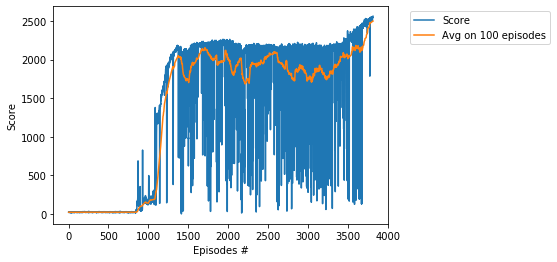

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

print('length of scores: ', len(scores), ', len of avg_scores: ', len(avg_scores))

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores, label="Score")
plt.plot(np.arange(1, len(avg_scores)+1), avg_scores, label="Avg on 100 episodes")
plt.legend(bbox_to_anchor=(1.05, 1)) 
plt.ylabel('Score')
plt.xlabel('Episodes #')
plt.show()

In [6]:
def play(env, agent, num_episodes):
    
    state = env.reset()
    scores_deque = deque(maxlen=100)
    scores = []
    
    for i_episode in range(num_episodes + 1):
        
        state = env.reset()
        score = 0                    
        time_start = time.time()
        
        while True:
            
            action = agent.select_action(state, eval=True)
            env.render()
            next_state, reward, done, _ = env.step(action)
            score += reward 
            state = next_state
    
            if done:
                break
                
        s = (int)(time.time() - time_start)
        
        scores_deque.append(score)
        scores.append(score)    
        
        print('Episode {}\tAverage Score: {:.2f},\tScore: {:.2f} \tTime: {:02}:{:02}:{:02}'\
                  .format(i_episode, np.mean(scores_deque), score, s//3600, s%3600//60, s%60)) 
    

In [7]:
play(env=env, agent=agent, num_episodes=5)

Episode 0	Average Score: 2588.79,	Score: 2588.79 	Time: 00:00:04
Episode 1	Average Score: 2598.40,	Score: 2608.00 	Time: 00:00:04
Episode 2	Average Score: 2593.40,	Score: 2583.42 	Time: 00:00:04
Episode 3	Average Score: 2591.13,	Score: 2584.30 	Time: 00:00:04
Episode 4	Average Score: 2588.70,	Score: 2579.00 	Time: 00:00:04
Episode 5	Average Score: 2589.58,	Score: 2593.98 	Time: 00:00:04


In [8]:
env.close()